In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Base Functions:

In [3]:
def get_image(path):
    img = cv2.imread(path)
    # img = cv2.cvtColor(img, cv2.cv.CV_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def show_img(img, title = None):
    scale_factor = 1.2
    plt.figure(figsize=(6*scale_factor,4*scale_factor))
    plt.subplot(111)
    plt.imshow(img, cmap='gray')
    plt.suptitle(title)
    plt.show()

    
def sidebyside(im1,im2, titles = ['img 1','img 2']):
    # Plot two images side by side
    scale_factor = 2.4
    plt.figure(figsize=(6*scale_factor,4*scale_factor))
    
    plt.subplot(1, 2, 1)         # #rows, #cols, plotnumber
    plt.imshow(im1, cmap='gray') # First plot
    plt.title(titles[0])

    plt.subplot(1, 2, 2)         # #rows, #cols, plotnumber
    plt.imshow(im2, cmap='gray') # plot in a separate subplot
    plt.title(titles[1])

    plt.show()


def img_diff(img1, img2, threshold = 60):
    gray1 = gray_blur(img1)
    gray2 = gray_blur(img2)
    
    dif = cv2.absdiff(gray1, gray2)
    dif = cv2.threshold(dif, threshold, 255, cv2.THRESH_BINARY)[1]
    
    show_img(dif)

    
def gray_blur(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.GaussianBlur(img, (21, 21), 0)
    return img


def event_diff(color_list, thresh=15):
    img_list = []          #  Create list of grayed, blurred images
    
    for im in color_list:
        img_list.append(gray_blur(im))
    
    def getdif(im1,im2):
        dif = cv2.absdiff(im1, im2)
        dif = cv2.threshold(dif, thresh, 255, cv2.THRESH_BINARY)[1]
        return dif
    
    # find common changes between an image and the image to the left and right
    # for now ignore first and last image
    for i, im in enumerate(img_list[1:-1]):
        # start w/ img_list[1] thus 'i' == index of the previous image
        prev = getdif(im, img_list[i])
        post = getdif(im, img_list[i+2])
        both = cv2.bitwise_and(prev,post)
        
        sidebyside(both, color_list[i+1], titles = ['motion','original'])

## Data Samples:

In [4]:
deer1 = get_image('../data/motion_test/EK000025-2.JPG')
deer2 = get_image('../data/motion_test/EK000026-2.JPG')
deer3 = get_image('../data/motion_test/EK000027-2.JPG')

In [5]:
data_dir = "../data/second_sample/BC Kettles/Site 1/"
for root, dirs, files in os.walk(data_dir):
#     for name in files:
#         print(os.path.join(root, name))
    for name in dirs:
        print(os.path.join(root, name))

../data/second_sample/BC Kettles/Site 1/April 2015
../data/second_sample/BC Kettles/Site 1/February 2015
../data/second_sample/BC Kettles/Site 1/January 2015
../data/second_sample/BC Kettles/Site 1/March 2015


In [6]:
event_bunch = []
for dr in os.listdir(data_dir)[1:]:
    ev = [get_image(os.path.join(data_dir, dr, im)) for im in os.listdir(os.path.join(data_dir, dr))]
    event_bunch.append(ev)

len(event_bunch)
    

4

In [ ]:
# event = [deer1, deer2, deer3]
# event_diff(event, thresh = 10)

Tasks:

- dilate white area
- create border
    - contour?
    - rectangle/square? (?aspect ratio)
    - ellipse/circle?
    
- dynamically choose threshold
- dynamically choose dilation 


Contemplate:

- what to feed CNN?
    - bordered region only?
    - border plus original?
    - border overlayed on original?

## Motion Dilation, Bounding Motion Region

In [17]:
def dilate(img1, img2, threshold = 15):
    kernel = np.ones((100,100),np.uint8)
    krn2 = np.ones((20,20),np.uint8)
    
    gray1 = gray_blur(img1)
    gray2 = gray_blur(img2)
    
    dif = cv2.absdiff(gray1, gray2)
    dif = cv2.threshold(dif, threshold, 255, cv2.THRESH_BINARY)[1]
    
    dif = cv2.morphologyEx(dif, cv2.MORPH_CLOSE, kernel)
    dif1 = dif

#     dif = cv2.morphologyEx(dif, cv2.MORPH_OPEN, kernel)
    dif = cv2.dilate(dif, krn2, iterations=2)
    dif2 = dif
    
#     (cnts, _) = cv2.findContours(dif.copy(), cv2.RETR_EXTERNAL,
#                 cv2.CHAIN_APPROX_SIMPLE)
    
    sidebyside(dif2,dif1, titles=['dilation','raw dif'])
        

def event_dilate(color_list, thresh=15):
    img_list = []          #  Create list of grayed, blurred images
    dilate_kernel = np.ones((100,100),np.uint8)
    
    def getdif(im1,im2):
        dif = cv2.absdiff(im1, im2)
        dif = cv2.threshold(dif, thresh, 255, cv2.THRESH_BINARY)[1]
        return dif
        
    for im in color_list:
        img_list.append(gray_blur(im))
        
    # find common changes between an image and the image to the left and right
    for i, im in enumerate(img_list):
        # wrapped to the other end to get the ends - not the best soln for long events
        before = (i-1)%len(img_list)
        after =  (i+1)%len(img_list)
        prev = getdif(im, img_list[before])
        post = getdif(im, img_list[after])
        both = cv2.bitwise_and(prev,post)
        both = cv2.dilate(both, dilate_kernel, iterations=2)
        both = cv2.cvtColor(both, cv2.COLOR_GRAY2RGB)
        overlap = cv2.bitwise_and(both,color_list[i])
        
        sidebyside(both, overlap, titles = ['motion','original'])

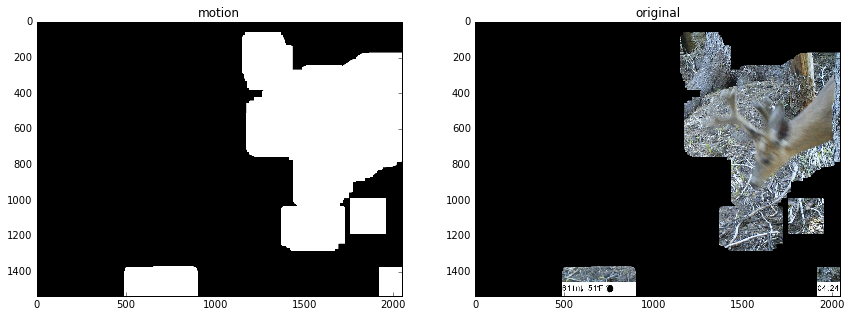

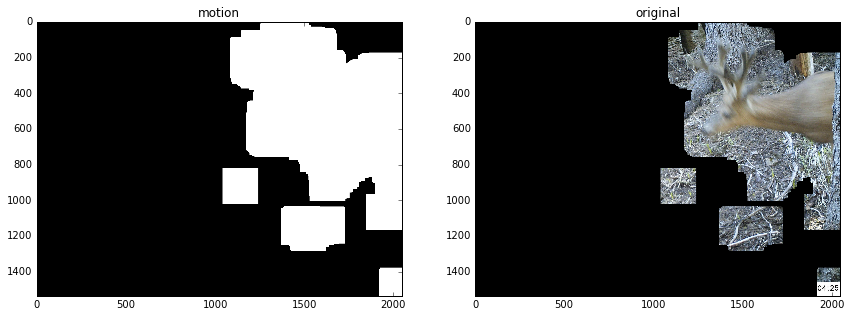

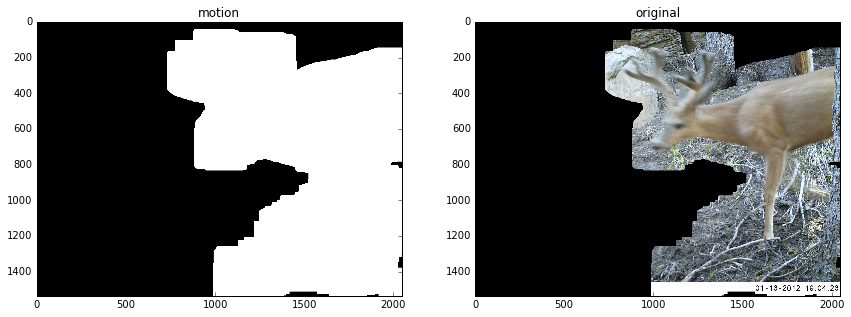

In [18]:
# dilate(deer1,deer2)
deers = [deer1, deer2, deer3]
event_dilate(deers)

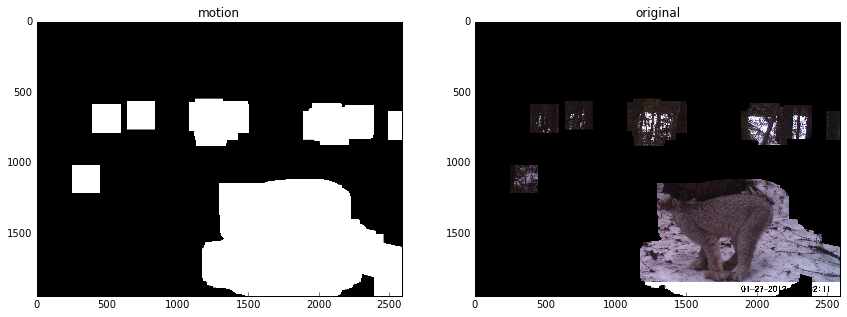

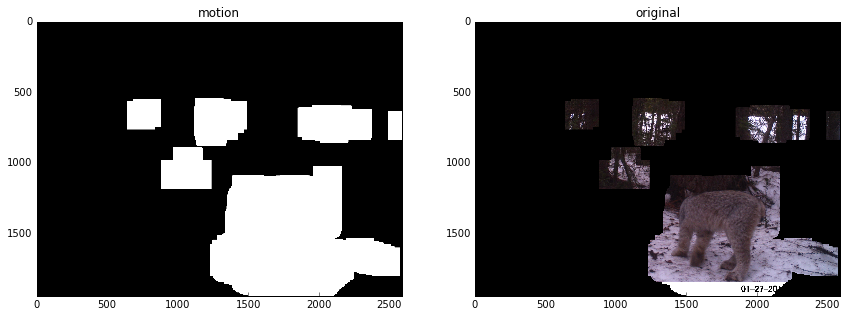

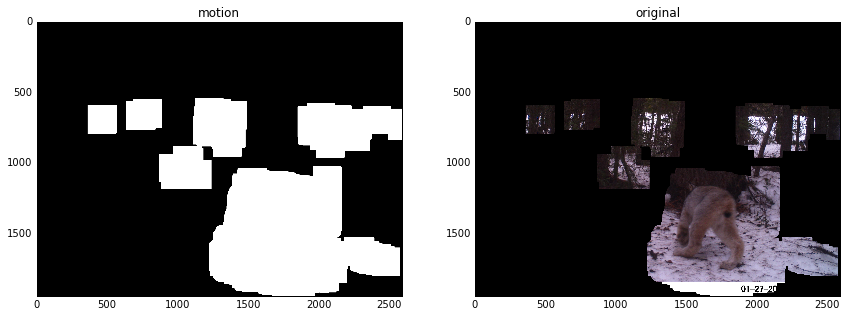

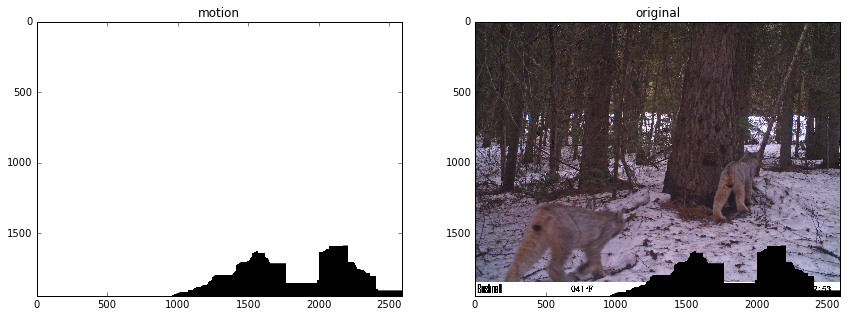

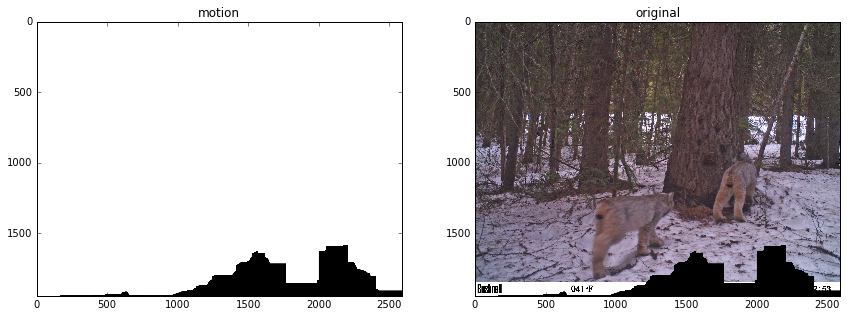

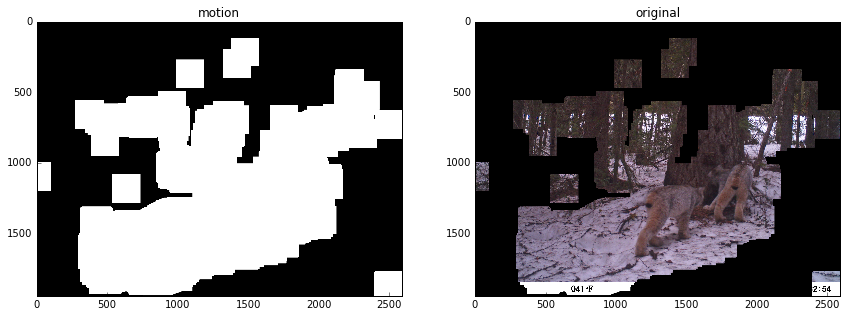

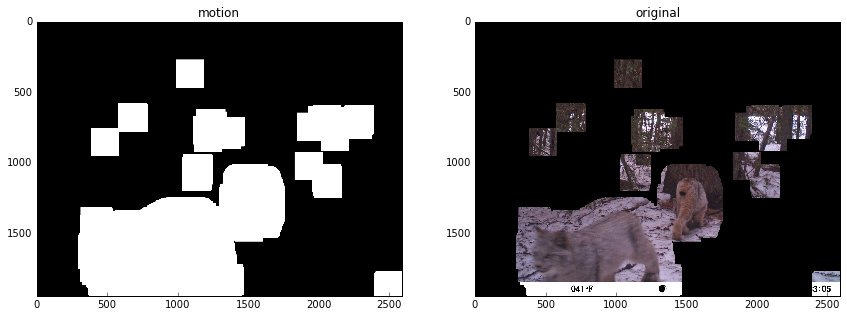

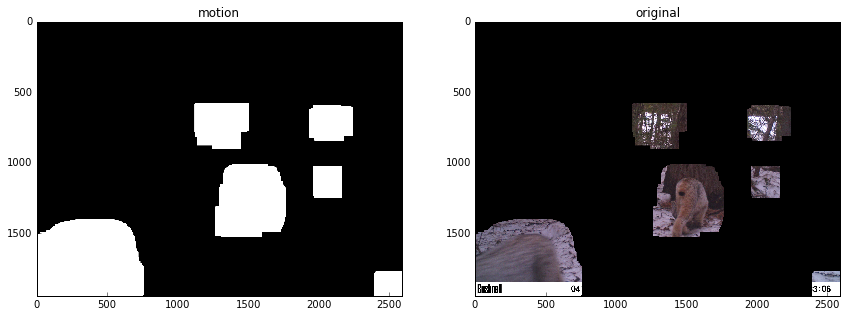

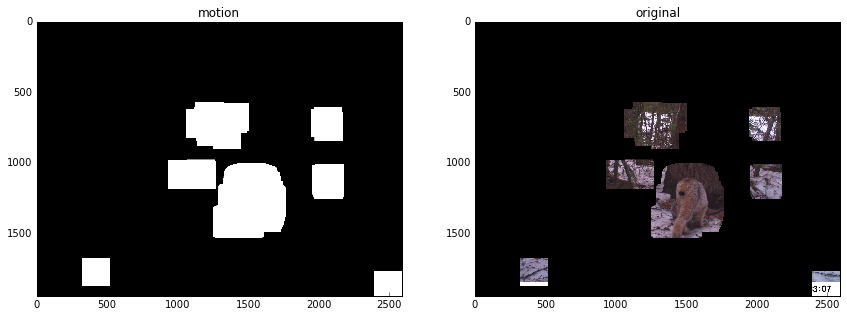

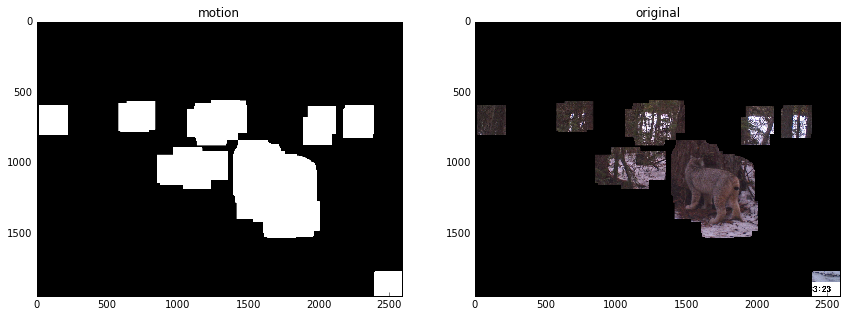

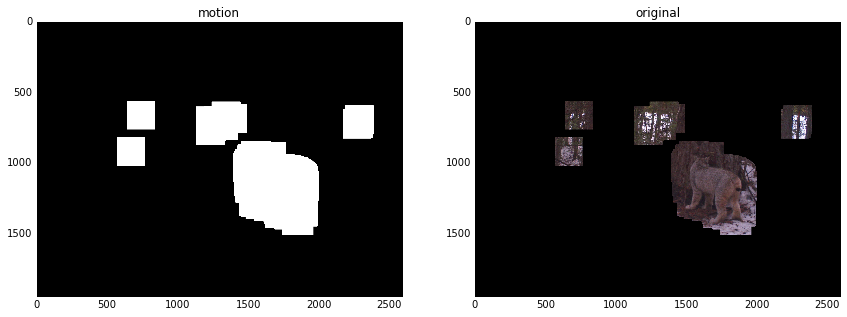

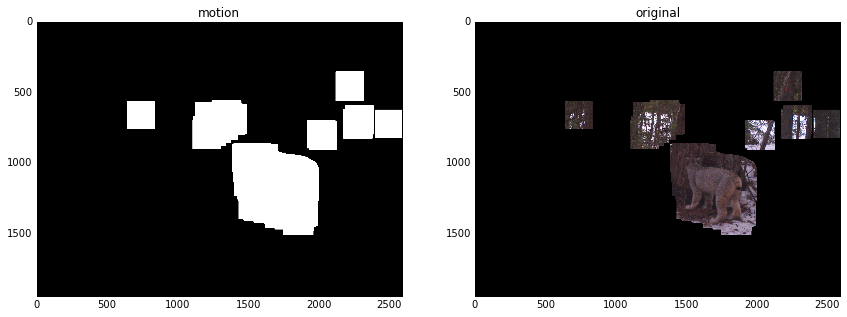

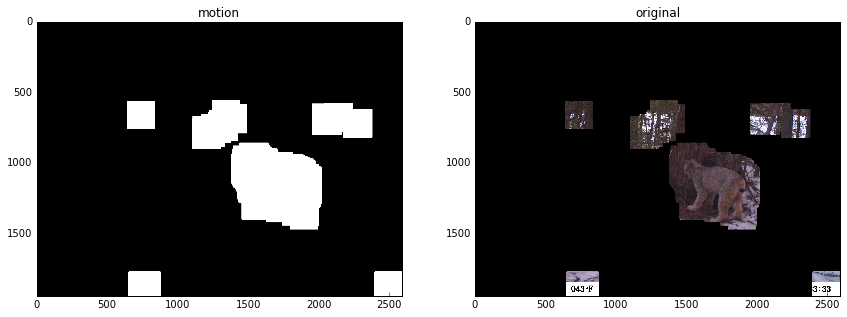

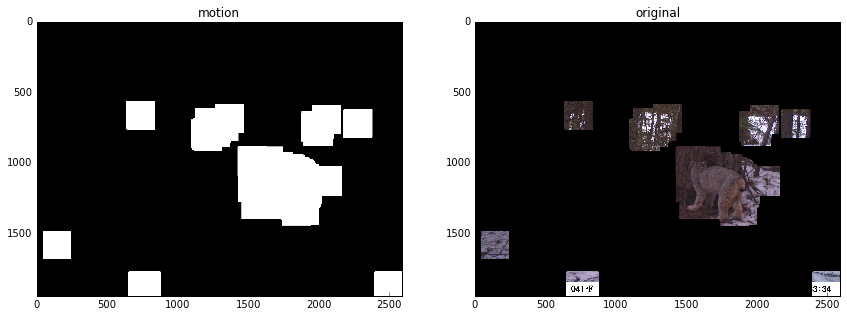

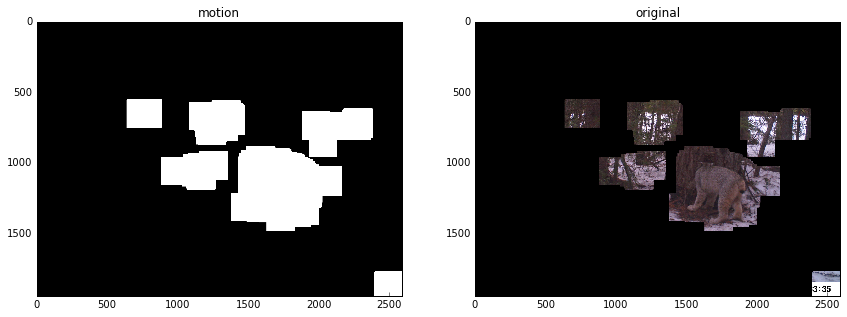

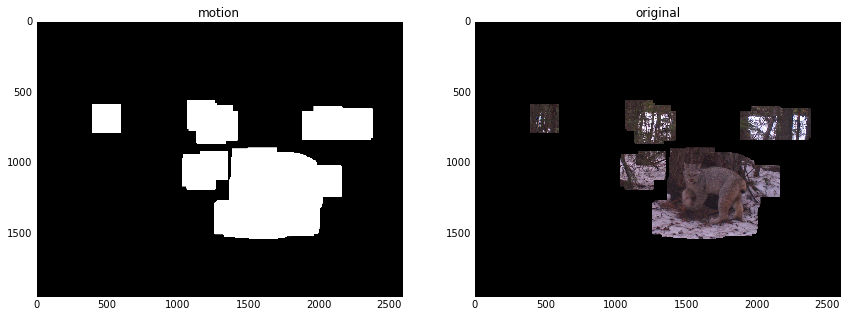

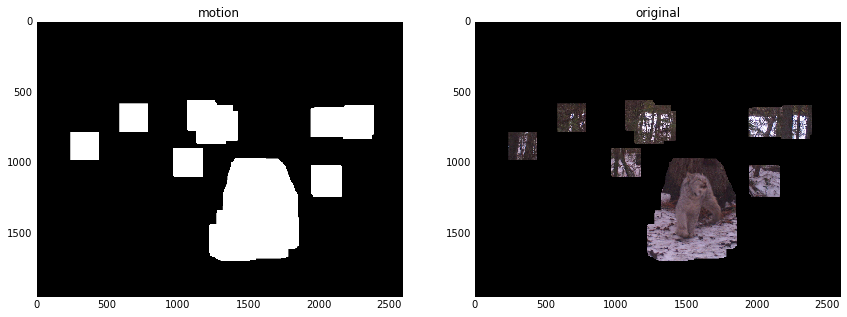

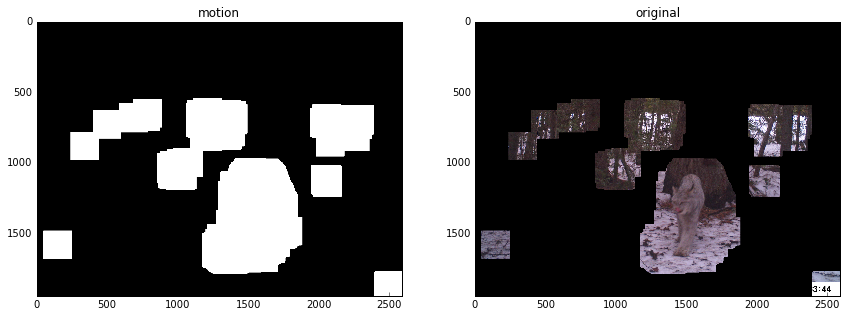

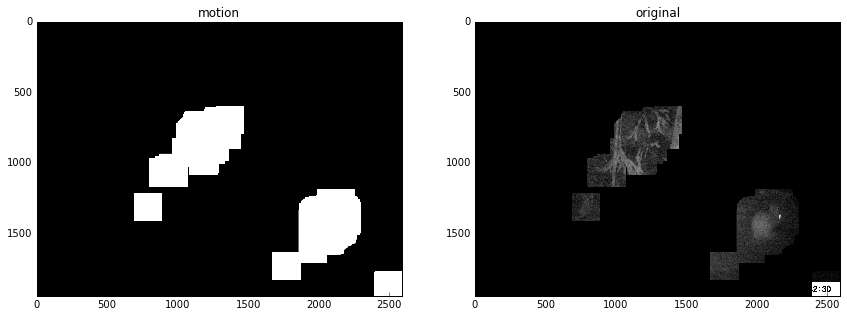

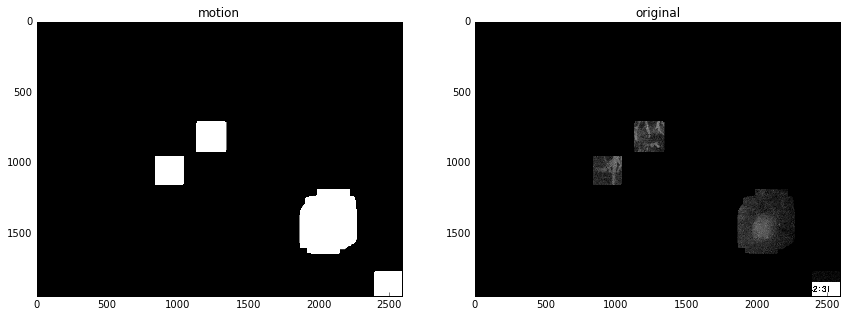

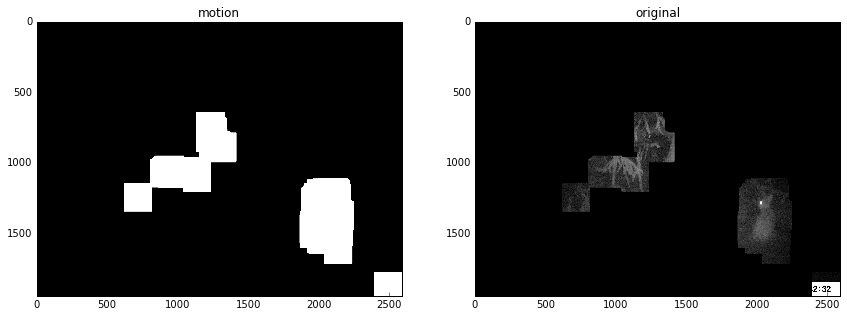

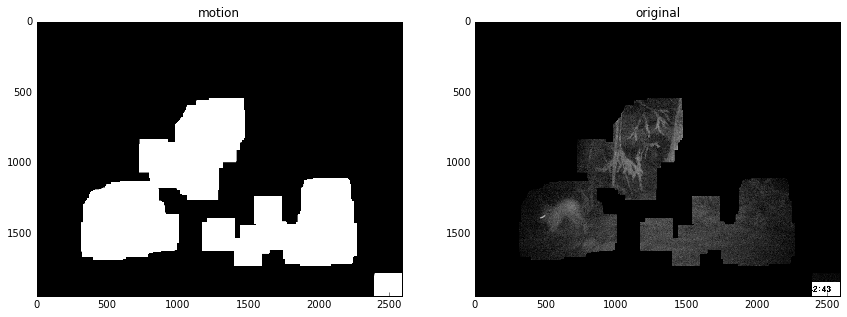

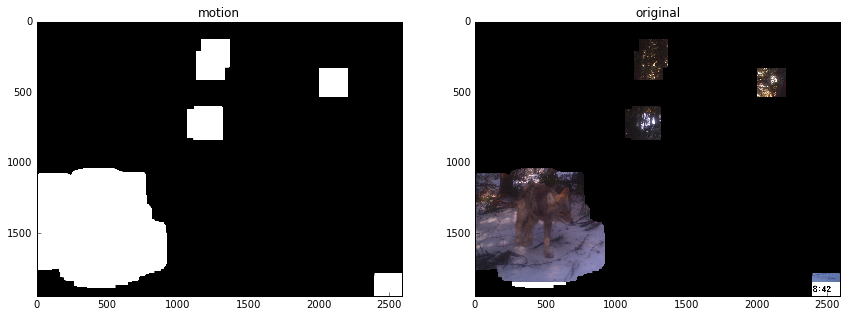

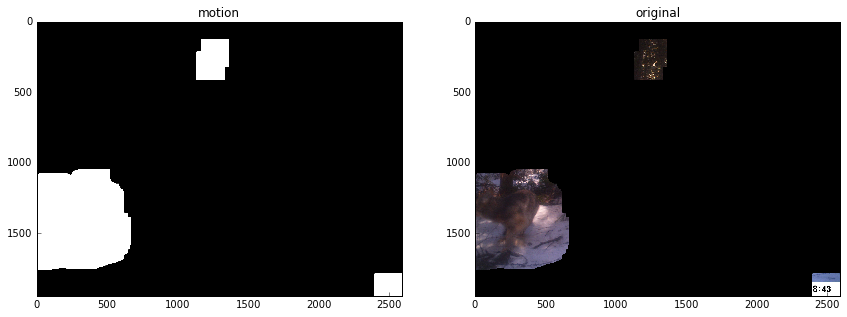

In [10]:
ev = event_bunch[0]
event_dilate(ev, thresh=5)

### Resources:

Dilation/Erosion, Opening/Closing: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html

Borrowed from:
http://www.pyimagesearch.com/2015/05/25/basic-motion-detection-and-tracking-with-python-and-opencv/#


```python
	# dilate the thresholded image to fill in holes, then find contours
	# on thresholded image
	thresh = cv2.dilate(thresh, None, iterations=2)
	(cnts, _) = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
 
	# loop over the contours
	for c in cnts:
		# if the contour is too small, ignore it
		if cv2.contourArea(c) < args["min_area"]:
			continue
 
		# compute the bounding box for the contour, draw it on the frame,
		# and update the text
		(x, y, w, h) = cv2.boundingRect(c)
		cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
		text = "Occupied"
```

## Notes, Questions:

Possible to speed up motion-highlight process?

How to interface with TF?

- preprocess and then save all images?
    then feed filenames of saved imgs into TF?
    
- can preprocessing be done in TF?

- convert preprocessed img to binary?
    then send directly to TF (which reads in binary in any case?